In [2]:
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
import time

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # To ignore SettingWithCopyWarning warning

# Import data

In [3]:
train = pd.read_csv("train.csv")
validation = pd.read_csv("validation.csv")

In [4]:
print(train.shape, validation.shape)

(2430981, 25) (303925, 25)


# Import Predictions

In [5]:
lr_preds = pd.read_csv("Prediction_csv/lr_pCTR.csv", index_col  = "Unnamed: 0")
rf_preds = pd.read_csv("Prediction_csv/rf_pCTR.csv", index_col  = "Unnamed: 0")
xgb_preds = pd.read_csv("Prediction_csv/xgb_pCTR.csv", index_col  = "Unnamed: 0")

In [13]:
base_bid = train.loc[ train["click"] == 1, "payprice"].mean()
basebid_max = train.loc[ train["click"] == 1, "payprice"].max()
basebid_min = train.loc[ train["click"] == 1, "payprice"].min()
avgCTR = train["click"].sum()*100/train.shape[0]

In [16]:
print("Base bid: {}, \nMax basebid: {} \nMin basebid: {} \navgCTR: {}".format(base_bid, 
                                                                                   basebid_max,
                                                                                   basebid_min,
                                                                                   avgCTR))

Base bid: 105.46402677077523, 
Max basebid: 300 
Min basebid: 4 
avgCTR: 0.07375623256619447


In [52]:
basebids = np.linspace(0.2*base_bid, 6*base_bid, 100)
basebids

array([ 21.09280535,  27.27150591,  33.45020647,  39.62890703,
        45.80760759,  51.98630815,  58.1650087 ,  64.34370926,
        70.52240982,  76.70111038,  82.87981094,  89.0585115 ,
        95.23721205, 101.41591261, 107.59461317, 113.77331373,
       119.95201429, 126.13071485, 132.3094154 , 138.48811596,
       144.66681652, 150.84551708, 157.02421764, 163.20291819,
       169.38161875, 175.56031931, 181.73901987, 187.91772043,
       194.09642099, 200.27512154, 206.4538221 , 212.63252266,
       218.81122322, 224.98992378, 231.16862434, 237.34732489,
       243.52602545, 249.70472601, 255.88342657, 262.06212713,
       268.24082769, 274.41952824, 280.5982288 , 286.77692936,
       292.95562992, 299.13433048, 305.31303104, 311.49173159,
       317.67043215, 323.84913271, 330.02783327, 336.20653383,
       342.38523439, 348.56393494, 354.7426355 , 360.92133606,
       367.10003662, 373.27873718, 379.45743773, 385.63613829,
       391.81483885, 397.99353941, 404.17223997, 410.35

# Linear Strategy

In [53]:
def LinearStrategy(sub_pCTR, sub_basebid):
    
    avgCTR = train["click"].sum()*100/train.shape[0]
    bidprice = (sub_pCTR["click_proba"] * sub_basebid) / avgCTR
    return bidprice

# Evaluate Results

In [54]:
budget = 6250*1000

def ValidationDataFrame(submission_pCTR, submission_basebid):
    
    validation_check = validation[["bidid", "click", "bidprice", "payprice"]]
    validation_check["click_proba"] = submission_pCTR["click_proba"]
    validation_check["bidprice_predicted"] = LinearStrategy(submission_pCTR, submission_basebid)
    
    return validation_check


def ValidateStrategy(df):
    
    impressions = 0
    clicks = 0
    cost = 0
    auctions_participated = 0
    balance = budget
    
    for row in df.iterrows():
        
        if cost < budget:
            
            auctions_participated+=1
            
            if (row[1]["bidprice_predicted"] >= row[1]["payprice"]):
                
                if (balance > row[1]["bidprice_predicted"]):
                    
                    impressions+=1
                    clicks+=row[1]["click"]
                    cost+=row[1]["payprice"]
                    balance-=row[1]["payprice"]
                else:
                    pass
    
        else:
            break
    
    # Metrics
    ctr = clicks*100/impressions
    cpm = cost/(impressions*1000)
    cpc = cost/clicks
    
    print("Strategy statistics:")
    print("Auctions participated: {} | Impressions: {} | Clicks: {} | Cost: {} | CTR: {} | CPM: {} | CPC: {}".format(auctions_participated, \
                                                                                                                     impressions, clicks, \
                                                                                                                     cost,\
                                                                                                                     np.round(ctr,5), \
                                                                                                                     np.round(cpm,5), \
                                                                                                                     np.round(cpc,2)))
    print("\n")
            
    return impressions, clicks, cost, auctions_participated, ctr, cpm, cpc

In [55]:
pCTR_preds = [lr_preds, rf_preds, xgb_preds]
pCTR_model_names = ["Logistic Regression", "Random Forest", "XGBoost"]
results = pd.DataFrame(columns = ["pCTR_model", "basebid", "Coefficient", "Impressions", "Clicks", "Cost", "CTR", "CPM", "CPC"])
i=0
k=0

start = time.time()

for pCTR_pred in pCTR_preds:
    for basebid_pred in basebids:
        
        # Strategy 1
        validation_check = ValidationDataFrame(pCTR_pred, basebid_pred)
        print("\033[1m pCTR model: {} \033[0m, \033[1m basebid price: {} \033[0m, \033[1m Coefficient: {} \033[0m ".format(pCTR_model_names[i], basebid_pred, basebid_pred/base_bid))
        impressions, clicks, cost, auctions_participated, ctr, cpm, cpc = ValidateStrategy(validation_check)
        results.loc[k] = [pCTR_model_names[i], basebid_pred, basebid_pred/base_bid, impressions, clicks, cost, ctr, cpm, cpc]
        k+=1           
    i+=1
    
end = time.time()
print("Total time: {} mins".format((end-start)/60))

 pCTR model: Logistic Regression ,  basebid price: 21.092805354155047 ,  Coefficient: 0.2  
Strategy statistics:
Auctions participated: 303925 | Impressions: 113577 | Clicks: 65 | Cost: 6249958 | CTR: 0.05723 | CPM: 0.05503 | CPC: 96153.2


 pCTR model: Logistic Regression ,  basebid price: 27.271505912442887 ,  Coefficient: 0.2585858585858586  
Strategy statistics:
Auctions participated: 303925 | Impressions: 99391 | Clicks: 61 | Cost: 6249884 | CTR: 0.06137 | CPM: 0.06288 | CPC: 102457.11


 pCTR model: Logistic Regression ,  basebid price: 33.45020647073073 ,  Coefficient: 0.31717171717171716  
Strategy statistics:
Auctions participated: 303925 | Impressions: 90165 | Clicks: 58 | Cost: 6249857 | CTR: 0.06433 | CPM: 0.06932 | CPC: 107756.16


 pCTR model: Logistic Regression ,  basebid price: 39.62890702901857 ,  Coefficient: 0.37575757575757573  
Strategy statistics:
Auctions participated: 303925 | Impressions: 84614 | Clicks: 53 | Cost: 6249829 | CTR: 0.06264 | CPM: 0.07386 | CPC: 

Strategy statistics:
Auctions participated: 303925 | Impressions: 79689 | Clicks: 51 | Cost: 6248974 | CTR: 0.064 | CPM: 0.07842 | CPC: 122528.9


 pCTR model: Logistic Regression ,  basebid price: 206.45382210279027 ,  Coefficient: 1.9575757575757573  
Strategy statistics:
Auctions participated: 303925 | Impressions: 79689 | Clicks: 51 | Cost: 6248974 | CTR: 0.064 | CPM: 0.07842 | CPC: 122528.9


 pCTR model: Logistic Regression ,  basebid price: 212.63252266107813 ,  Coefficient: 2.016161616161616  
Strategy statistics:
Auctions participated: 303925 | Impressions: 79689 | Clicks: 51 | Cost: 6248974 | CTR: 0.064 | CPM: 0.07842 | CPC: 122528.9


 pCTR model: Logistic Regression ,  basebid price: 218.81122321936596 ,  Coefficient: 2.0747474747474746  
Strategy statistics:
Auctions participated: 303925 | Impressions: 79687 | Clicks: 51 | Cost: 6248850 | CTR: 0.064 | CPM: 0.07842 | CPC: 122526.47


 pCTR model: Logistic Regression ,  basebid price: 224.9899237776538 ,  Coefficient: 2.1333

Strategy statistics:
Auctions participated: 303925 | Impressions: 79678 | Clicks: 51 | Cost: 6247989 | CTR: 0.06401 | CPM: 0.07842 | CPC: 122509.59


 pCTR model: Logistic Regression ,  basebid price: 391.8148388514255 ,  Coefficient: 3.715151515151515  
Strategy statistics:
Auctions participated: 303925 | Impressions: 79678 | Clicks: 51 | Cost: 6248042 | CTR: 0.06401 | CPM: 0.07842 | CPC: 122510.63


 pCTR model: Logistic Regression ,  basebid price: 397.9935394097133 ,  Coefficient: 3.7737373737373727  
Strategy statistics:
Auctions participated: 303925 | Impressions: 79677 | Clicks: 51 | Cost: 6247919 | CTR: 0.06401 | CPM: 0.07842 | CPC: 122508.22


 pCTR model: Logistic Regression ,  basebid price: 404.17223996800124 ,  Coefficient: 3.8323232323232324  
Strategy statistics:
Auctions participated: 303925 | Impressions: 79677 | Clicks: 51 | Cost: 6247919 | CTR: 0.06401 | CPM: 0.07842 | CPC: 122508.22


 pCTR model: Logistic Regression ,  basebid price: 410.35094052628904 ,  Coefficie

Strategy statistics:
Auctions participated: 303925 | Impressions: 79667 | Clicks: 51 | Cost: 6246995 | CTR: 0.06402 | CPM: 0.07841 | CPC: 122490.1


 pCTR model: Logistic Regression ,  basebid price: 577.1758556000608 ,  Coefficient: 5.472727272727273  
Strategy statistics:
Auctions participated: 303925 | Impressions: 79669 | Clicks: 51 | Cost: 6246982 | CTR: 0.06401 | CPM: 0.07841 | CPC: 122489.84


 pCTR model: Logistic Regression ,  basebid price: 583.3545561583486 ,  Coefficient: 5.531313131313131  
Strategy statistics:
Auctions participated: 303925 | Impressions: 79668 | Clicks: 51 | Cost: 6246956 | CTR: 0.06402 | CPM: 0.07841 | CPC: 122489.33


 pCTR model: Logistic Regression ,  basebid price: 589.5332567166364 ,  Coefficient: 5.589898989898989  
Strategy statistics:
Auctions participated: 303925 | Impressions: 79667 | Clicks: 51 | Cost: 6246907 | CTR: 0.06402 | CPM: 0.07841 | CPC: 122488.37


 pCTR model: Logistic Regression ,  basebid price: 595.7119572749243 ,  Coefficient: 5

Strategy statistics:
Auctions participated: 303925 | Impressions: 92148 | Clicks: 66 | Cost: 6249988 | CTR: 0.07162 | CPM: 0.06783 | CPC: 94696.79


 pCTR model: Random Forest ,  basebid price: 175.56031931135107 ,  Coefficient: 1.6646464646464643  
Strategy statistics:
Auctions participated: 303925 | Impressions: 91414 | Clicks: 63 | Cost: 6249991 | CTR: 0.06892 | CPM: 0.06837 | CPC: 99206.21


 pCTR model: Random Forest ,  basebid price: 181.73901986963892 ,  Coefficient: 1.723232323232323  
Strategy statistics:
Auctions participated: 303925 | Impressions: 90775 | Clicks: 63 | Cost: 6249990 | CTR: 0.0694 | CPM: 0.06885 | CPC: 99206.19


 pCTR model: Random Forest ,  basebid price: 187.91772042792675 ,  Coefficient: 1.7818181818181815  
Strategy statistics:
Auctions participated: 303925 | Impressions: 90175 | Clicks: 63 | Cost: 6249987 | CTR: 0.06986 | CPM: 0.06931 | CPC: 99206.14


 pCTR model: Random Forest ,  basebid price: 194.09642098621458 ,  Coefficient: 1.84040404040404  
Stra

Strategy statistics:
Auctions participated: 303925 | Impressions: 82196 | Clicks: 54 | Cost: 6249990 | CTR: 0.0657 | CPM: 0.07604 | CPC: 115740.56


 pCTR model: Random Forest ,  basebid price: 360.9213360599863 ,  Coefficient: 3.4222222222222216  
Strategy statistics:
Auctions participated: 303925 | Impressions: 82081 | Clicks: 54 | Cost: 6249987 | CTR: 0.06579 | CPM: 0.07614 | CPC: 115740.5


 pCTR model: Random Forest ,  basebid price: 367.1000366182741 ,  Coefficient: 3.48080808080808  
Strategy statistics:
Auctions participated: 303925 | Impressions: 81967 | Clicks: 54 | Cost: 6249982 | CTR: 0.06588 | CPM: 0.07625 | CPC: 115740.41


 pCTR model: Random Forest ,  basebid price: 373.278737176562 ,  Coefficient: 3.539393939393939  
Strategy statistics:
Auctions participated: 303925 | Impressions: 81860 | Clicks: 53 | Cost: 6249991 | CTR: 0.06474 | CPM: 0.07635 | CPC: 117924.36


 pCTR model: Random Forest ,  basebid price: 379.4574377348498 ,  Coefficient: 3.5979797979797974  
Strate

Strategy statistics:
Auctions participated: 303925 | Impressions: 80401 | Clicks: 51 | Cost: 6249994 | CTR: 0.06343 | CPM: 0.07774 | CPC: 122548.9


 pCTR model: Random Forest ,  basebid price: 552.4610533669094 ,  Coefficient: 5.238383838383838  
Strategy statistics:
Auctions participated: 303925 | Impressions: 80373 | Clicks: 51 | Cost: 6249980 | CTR: 0.06345 | CPM: 0.07776 | CPC: 122548.63


 pCTR model: Random Forest ,  basebid price: 558.6397539251973 ,  Coefficient: 5.296969696969697  
Strategy statistics:
Auctions participated: 303925 | Impressions: 80356 | Clicks: 51 | Cost: 6249992 | CTR: 0.06347 | CPM: 0.07778 | CPC: 122548.86


 pCTR model: Random Forest ,  basebid price: 564.8184544834851 ,  Coefficient: 5.355555555555555  
Strategy statistics:
Auctions participated: 303925 | Impressions: 80321 | Clicks: 51 | Cost: 6249994 | CTR: 0.0635 | CPM: 0.07781 | CPC: 122548.9


 pCTR model: Random Forest ,  basebid price: 570.9971550417729 ,  Coefficient: 5.4141414141414135  
Strate

Strategy statistics:
Auctions participated: 303925 | Impressions: 104282 | Clicks: 155 | Cost: 5225208 | CTR: 0.14864 | CPM: 0.05011 | CPC: 33711.02


 pCTR model: XGBoost ,  basebid price: 126.13071484504835 ,  Coefficient: 1.195959595959596  
Strategy statistics:
Auctions participated: 303925 | Impressions: 107818 | Clicks: 157 | Cost: 5466316 | CTR: 0.14562 | CPM: 0.0507 | CPC: 34817.3


 pCTR model: XGBoost ,  basebid price: 132.30941540333617 ,  Coefficient: 1.2545454545454542  
Strategy statistics:
Auctions participated: 303925 | Impressions: 111200 | Clicks: 160 | Cost: 5699593 | CTR: 0.14388 | CPM: 0.05126 | CPC: 35622.46


 pCTR model: XGBoost ,  basebid price: 138.48811596162403 ,  Coefficient: 1.313131313131313  
Strategy statistics:
Auctions participated: 303925 | Impressions: 114487 | Clicks: 161 | Cost: 5936898 | CTR: 0.14063 | CPM: 0.05186 | CPC: 36875.14


 pCTR model: XGBoost ,  basebid price: 144.66681651991186 ,  Coefficient: 1.3717171717171714  
Strategy statistics:

Strategy statistics:
Auctions participated: 303925 | Impressions: 102363 | Clicks: 103 | Cost: 6249999 | CTR: 0.10062 | CPM: 0.06106 | CPC: 60679.6


 pCTR model: XGBoost ,  basebid price: 317.67043215197145 ,  Coefficient: 3.012121212121212  
Strategy statistics:
Auctions participated: 303925 | Impressions: 101971 | Clicks: 101 | Cost: 6249996 | CTR: 0.09905 | CPM: 0.06129 | CPC: 61881.15


 pCTR model: XGBoost ,  basebid price: 323.84913271025925 ,  Coefficient: 3.07070707070707  
Strategy statistics:
Auctions participated: 303925 | Impressions: 101627 | Clicks: 99 | Cost: 6249997 | CTR: 0.09742 | CPM: 0.0615 | CPC: 63131.28


 pCTR model: XGBoost ,  basebid price: 330.02783326854706 ,  Coefficient: 3.1292929292929283  
Strategy statistics:
Auctions participated: 303925 | Impressions: 101308 | Clicks: 98 | Cost: 6249997 | CTR: 0.09673 | CPM: 0.06169 | CPC: 63775.48


 pCTR model: XGBoost ,  basebid price: 336.20653382683497 ,  Coefficient: 3.1878787878787875  
Strategy statistics:
Au

Strategy statistics:
Auctions participated: 303925 | Impressions: 95175 | Clicks: 81 | Cost: 6249998 | CTR: 0.08511 | CPM: 0.06567 | CPC: 77160.47


 pCTR model: XGBoost ,  basebid price: 509.21014945889453 ,  Coefficient: 4.828282828282828  
Strategy statistics:
Auctions participated: 303925 | Impressions: 95048 | Clicks: 81 | Cost: 6249997 | CTR: 0.08522 | CPM: 0.06576 | CPC: 77160.46


 pCTR model: XGBoost ,  basebid price: 515.3888500171823 ,  Coefficient: 4.886868686868686  
Strategy statistics:
Auctions participated: 303925 | Impressions: 94891 | Clicks: 80 | Cost: 6249998 | CTR: 0.08431 | CPM: 0.06587 | CPC: 78124.98


 pCTR model: XGBoost ,  basebid price: 521.5675505754701 ,  Coefficient: 4.945454545454544  
Strategy statistics:
Auctions participated: 303925 | Impressions: 94712 | Clicks: 80 | Cost: 6249997 | CTR: 0.08447 | CPM: 0.06599 | CPC: 78124.96


 pCTR model: XGBoost ,  basebid price: 527.746251133758 ,  Coefficient: 5.004040404040404  
Strategy statistics:
Auctions pa

In [79]:
results.to_csv("ValidationSet_Evaluation_Results_LinearStartegy.csv")

In [89]:
results.head()

,pCTR_model,basebid,Coefficient,Impressions,Clicks,Cost,CTR,CPM,CPC
0,Logistic Regression,21.092805,0.200000,113577,65,6249958,0.057230,0.055028,96153.200000
2,Logistic Regression,27.271506,0.258586,99391,61,6249884,0.061374,0.062882,102457.114754
4,Logistic Regression,33.450206,0.317172,90165,58,6249857,0.064327,0.069316,107756.155172
6,Logistic Regression,39.628907,0.375758,84614,53,6249829,0.062637,0.073863,117921.301887
8,Logistic Regression,45.807608,0.434343,81140,52,6249808,0.064087,0.077025,120188.615385


In [126]:
results.groupby(["pCTR_model"], as_index=False)["Clicks"].max()

,pCTR_model,Clicks
0,Logistic Regression,65
1,Random Forest,152
2,XGBoost,162


In [131]:
idx = results.groupby(['pCTR_model'])['Clicks'].transform(max) == results['Clicks']
results[idx]

,pCTR_model,basebid,Coefficient,Impressions,Clicks,Cost,CTR,CPM,CPC
0,Logistic Regression,21.092805,0.200000,113577,65,6249958,0.057230,0.055028,96153.200000
208,Random Forest,45.807608,0.434343,137778,152,5926525,0.110322,0.043015,38990.296053
440,XGBoost,144.666817,1.371717,117648,162,6161517,0.137699,0.052372,38034.055556


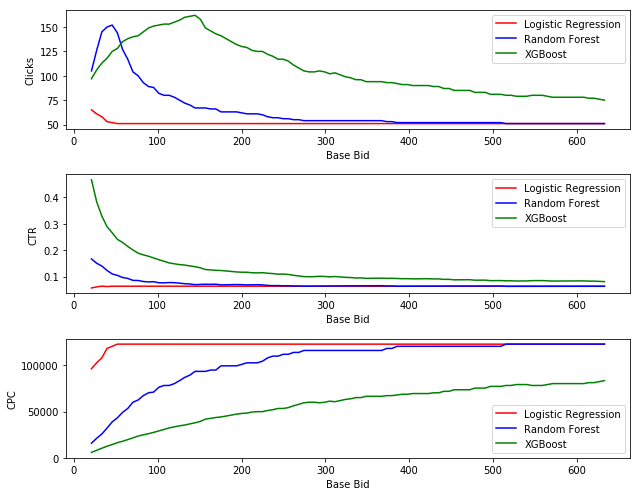

In [115]:
plt.figure(figsize = (9,7))

plt.subplot(3,1,1)
plt.plot(basebids, results.loc[results["pCTR_model"] == "Logistic Regression", "Clicks"].values, "r")
plt.plot(basebids, results.loc[results["pCTR_model"] == "Random Forest", "Clicks"].values, "b")
plt.plot(basebids, results.loc[results["pCTR_model"] == "XGBoost", "Clicks"].values, "g")

plt.xlabel("Base Bid")
plt.ylabel("Clicks")
plt.legend(pCTR_model_names)

plt.subplot(3,1,2)
plt.plot(basebids, results.loc[results["pCTR_model"] == "Logistic Regression", "CTR"].values, "r")
plt.plot(basebids, results.loc[results["pCTR_model"] == "Random Forest", "CTR"].values, "b")
plt.plot(basebids, results.loc[results["pCTR_model"] == "XGBoost", "CTR"].values, "g")

plt.xlabel("Base Bid")
plt.ylabel("CTR")
plt.legend(pCTR_model_names)

plt.subplot(3,1,3)
plt.plot(basebids, results.loc[results["pCTR_model"] == "Logistic Regression", "CPC"].values, "r")
plt.plot(basebids, results.loc[results["pCTR_model"] == "Random Forest", "CPC"].values, "b")
plt.plot(basebids, results.loc[results["pCTR_model"] == "XGBoost", "CPC"].values, "g")

plt.xlabel("Base Bid")
plt.ylabel("CPC")
plt.legend(pCTR_model_names)

plt.tight_layout()
plt.savefig("Linear_Strategy_Results.png")

In [124]:
# lr_res = results.loc[results["pCTR_model"] == "Logistic Regression"].copy()
# rf_res = results.loc[results["pCTR_model"] == "Random Forest"].copy()
# xgb_res = results.loc[results["pCTR_model"] == "XGBoost"].copy()

# lr_best_basebid = lr_res.loc[lr_res["Clicks"] == lr_res["Clicks"].max()]["basebid"][0]
# rf_best_basebid = rf_res.loc[rf_res["Clicks"] == rf_res["Clicks"].max()]["basebid"].values[0]
# xgb_best_basebid = xgb_res.loc[xgb_res["Clicks"] == xgb_res["Clicks"].max()]["basebid"].values[0]

# print("Logistic Regression max clicks for basebid = {}".format(lr_best_basebid))
# print("Random Forest max clicks for basebid = {}".format(rf_best_basebid))
# print("XGBoost max clicks for basebid = {}".format(xgb_best_basebid))

Logistic Regression max clicks for basebid = 21.092805354155047
Random Forest max clicks for basebid = 45.80760758730641
XGBoost max clicks for basebid = 144.66681651991186
